In [1]:
import nltk
from nltk.corpus import stopwords, names
from nltk.corpus import names as nm
import string
import names
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
import pandas as pd
import pickle
import numpy as np
import csv

In [2]:
processed_script_train_lemme=pickle.load(open('processed_script_train_lemme.p','rb'))

In [3]:
processed_script_test_lemme = pickle.load(open('processed_script_test_lemme.p','rb'))

In [4]:
y_train = pickle.load(open('y_train.p','rb'))

In [5]:
y_test = pickle.load(open('y_test.p','rb'))

# FreqDist

##### With Lemme

In [6]:
processed_scripts_freqdist_train_lemme = list(map(FreqDist, processed_script_train_lemme))

In [55]:
processed_scripts_freqdist_train_lemme[0]

FreqDist({'hawkeye': 348, 'heyward': 238, 'uncas': 153, 'magua': 140, 'huron': 134, 'chingachgook': 130, 'munro': 126, 'look': 101, 'cut': 90, 'hand': 88, ...})

In [7]:
processed_scripts_freqdist_test_lemme = list(map(FreqDist, processed_script_test_lemme))

##### With Lemme

In [ ]:
df_lemme = pd.DataFrame(processed_scripts_freqdist_train_lemme[0], index=[0])
for i in range(1,len(processed_scripts_freqdist_train_lemme)):
    try:
        right_lemme = pd.DataFrame(processed_scripts_freqdist_train_lemme[i], index=[i])
        print(right_lemme.head(1), right_lemme.shape)
        df_lemme = pd.concat([df_lemme, right_lemme],  ignore_index=True)
        print('success')
    except:
        print('fail')
        continue
for i in range(0,len(processed_scripts_freqdist_test_lemme)):
    try:
        right_lemme = pd.DataFrame(processed_scripts_freqdist_test_lemme[i], index=[i])
        print(right_lemme.head(1), right_lemme.shape)
        df_lemme = pd.concat([df_lemme, right_lemme],  ignore_index=True)
        print('success')
    except:
        print('fail', keys_list_train[i])
        continue

In [ ]:
df_lemme.shape

In [ ]:
df_lemme.fillna(value=0,axis=0, inplace=True)

In [8]:
# pickle.dump(df_lemme,open('df_lemme.p','wb'))

In [ ]:
df_lemme_filtered = df_lemme.copy()

In [ ]:
for word in df_lemme_filtered.columns[2:]:
    counts = df_lemme_filtered[word].value_counts().reset_index()
    if counts[counts['index']!=0.0][word].sum()<2:
        df_lemme_filtered.drop(word,axis=1,inplace=True)
df_lemme_filtered.head()

In [ ]:
# pickle.dump(df_lemme_filtered,open('df_lemme_filtered_2+.p','wb'))

Dropping words that only appear in a handful of scripts. They are not going to be good features since they will have very few overlap with other movies.

|Number of movies |  Words left |
|-----------------|-------------|
|2+               |   24624     |
|3+               |   12435     |
|4+               |   11209     |
|5+               |   10251     |
|6+               |   9483      |
|7+               |   8823      |
|10+              |   8308      |
|15+              |   6476      |

In [ ]:
new_df_full = pd.DataFrame(index=df_lemme_filtered.index)
for index, row in df_lemme_filtered.iterrows():
    words = row[2:].sort_values(ascending=False)[:25].index.tolist()
    for word in words:
        new_df_full[word] = df_lemme_filtered[word]
new_df_full
# new_df = pd.DataFrame(index=full_train_df_lemme_filtered['Movie_name'])
# new_df.append(full_train_df_lemme_filtered['Genre_label'])
# new_df.head()

In [ ]:
new_df_full.shape

In [ ]:
# pickle.dump(new_df_full,open('new_df_full.p','wb'))

In [9]:
new_df_full=pickle.load(open('new_df_full.p','rb'))

# Split Train and Test

In [10]:
X_train_df = new_df_full[0:276]

In [12]:
X_train_df.head();

In [13]:
len(y_train)

276

In [14]:
X_test_df = new_df_full[276:]

In [15]:
X_test_df.head();

In [16]:
len(y_test)

72

# TF-IDF

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
c_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [19]:
X_train_blobbed=list(map(lambda script :' '.join(script), processed_script_train_lemme))

In [20]:
X_test_blobbed=list(map(lambda script :' '.join(script), processed_script_test_lemme))

In [21]:
tf_idf_data_train = tfidf_vectorizer.fit_transform(X_train_blobbed)

In [22]:
tf_idf_data_train.shape

(276, 43851)

In [23]:
tf_idf_data_test = tfidf_vectorizer.transform(X_test_blobbed)

In [24]:
tf_idf_data_test.shape

(72, 43851)

# Modeling Time!!!!!!!!!!!

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier

In [26]:
Dummy = DummyClassifier()

In [27]:
Dummy.fit(X_train_df, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [28]:
dummy_preds = Dummy.predict(X_test_df)

In [31]:
print_metrics(y_test,dummy_preds)

Precision Score: 0.3491358024691358
Recall Score: 0.34722222222222215
Accuracy Score: 0.3472222222222222
F1 Score: 0.3466356239465483


Normalized confusion matrix


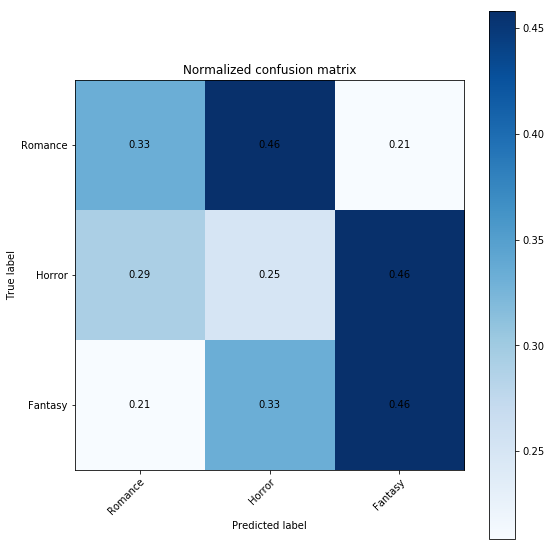

In [34]:
plot_confusion_matrix(y_test,dummy_preds,normalize=True)

In [30]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels,preds,average='macro')))
    print("Recall Score: {}".format(recall_score(labels,preds,average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(labels,preds)))
    print("F1 Score: {}".format(f1_score(labels,preds,average='macro')))

In [33]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = unique_labels(y_true, y_pred)
    classes = ['Romance','Horror','Fantasy']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
X_train_df.head()

In [35]:
forest_vanilla = RandomForestClassifier()
forest_vanilla.fit(X_train_df, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
y_hat_train_v_rf = forest_vanilla.predict(X_train_df)
y_hat_test_v_rf = forest_vanilla.predict(X_test_df)
accuracy_score(y_train, y_hat_train_v_rf), accuracy_score(y_test, y_hat_test_v_rf)

(0.9202898550724637, 0.5694444444444444)

In [37]:
print_metrics(y_test,y_hat_test_v_rf)

Precision Score: 0.5674603174603174
Recall Score: 0.5694444444444444
Accuracy Score: 0.5694444444444444
F1 Score: 0.5660450660450661


Normalized confusion matrix


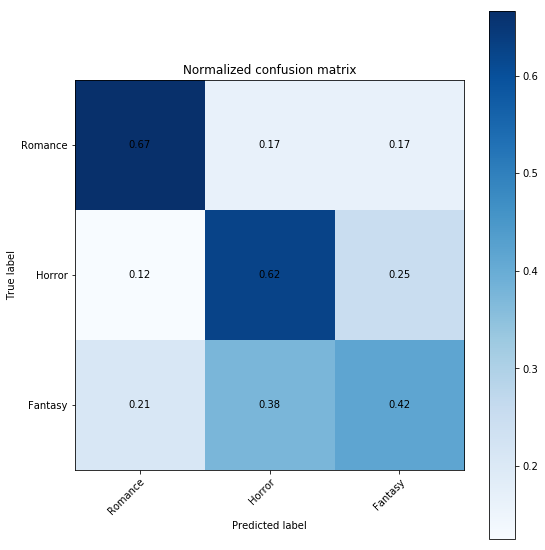

In [38]:
plot_confusion_matrix(y_test,y_hat_test_v_rf,normalize=True)

In [39]:
param_grid_rf = {'n_estimators':[80,100,120,140],
    'criterion':['gini','entropy'],
    'max_depth':[160,180,200,220,240],
    'min_samples_split':[18,20,22,24,26]
                }

In [40]:
from sklearn.model_selection import GridSearchCV
grid_clf = GridSearchCV(forest_vanilla, param_grid_rf, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_df, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_hat_train_choc_rf = grid_clf.predict(X_train_df)
y_hat_test_choc_rf = grid_clf.predict(X_test_df)
training_accuracy = accuracy_score(y_train, y_hat_train_choc_rf)
val_accuracy = accuracy_score(y_test, y_hat_test_choc_rf)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 240
min_samples_split: 18
n_estimators: 100

Training Accuracy: 89.49%
Validation accuracy: 63.89%


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
print_metrics(y_test,y_hat_test_choc_rf)

Precision Score: 0.6440446127946128
Recall Score: 0.6388888888888888
Accuracy Score: 0.6388888888888888
F1 Score: 0.6326777087646653


Normalized confusion matrix


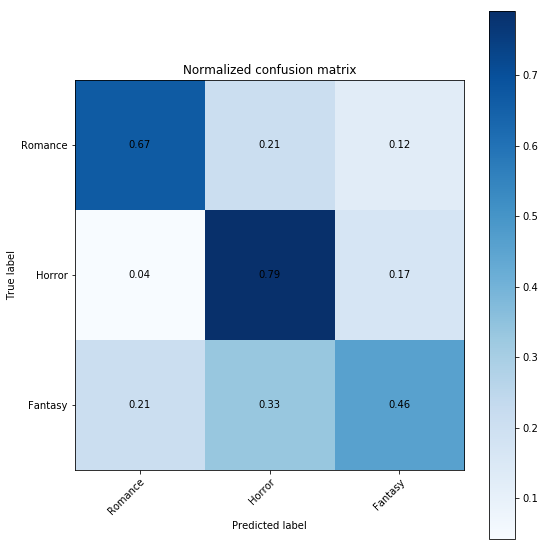

In [42]:
plot_confusion_matrix(y_test,y_hat_test_choc_rf,normalize=True)

In [43]:
forest_tfidif = RandomForestClassifier()
forest_tfidif.fit(tf_idf_data_train, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
y_hat_train_tfidf_rf = forest_tfidif.predict(tf_idf_data_train)
y_hat_test_tfidf_rf = forest_tfidif.predict(tf_idf_data_test)
accuracy_score(y_train, y_hat_train_tfidf_rf), accuracy_score(y_test, y_hat_test_tfidf_rf)

(0.9202898550724637, 0.5555555555555556)

In [45]:
print_metrics(y_test,y_hat_test_tfidf_rf)

Precision Score: 0.5407011289364231
Recall Score: 0.5555555555555556
Accuracy Score: 0.5555555555555556
F1 Score: 0.5379124729462398


Normalized confusion matrix


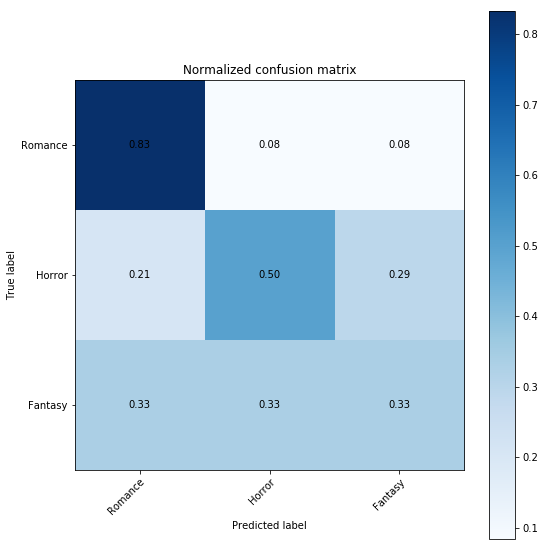

In [46]:
plot_confusion_matrix(y_test,y_hat_test_tfidf_rf,normalize=True)

In [ ]:
param_grid_rf_tfidf = {'n_estimators':[80,100,120,140],
    'criterion':['gini','entropy'],
    'max_depth':[160,180,200,220,240],
    'min_samples_split':[18,20,22,24,26]
                }

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_clf_tfidf = GridSearchCV(forest_tfidif, param_grid_rf_tfidf, scoring='accuracy', cv=None, n_jobs=1)
grid_clf_tfidf.fit(tf_idf_data_train, y_train)

best_parameters = grid_clf_tfidf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_hat_train_tfidf_rf = grid_clf_tfidf.predict(tf_idf_data_train)
y_hat_test_tfidf_rf = grid_clf_tfidf.predict(tf_idf_data_test)
training_accuracy = accuracy_score(y_train, y_hat_train_tfidf_rf)
val_accuracy = accuracy_score(y_test, y_hat_test_tfidf_rf)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
print_metrics(y_test,y_hat_test_tfidf_rf)

In [ ]:
plot_confusion_matrix(y_test,y_hat_test_tfidf_rf,normalize=True)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_df,y_train)
y_hat_train_v_nb = mnb.predict(X_train_df)
y_hat_test_v_nb = mnb.predict(X_test_df)
accuracy_score(y_train, y_hat_train_v_nb), accuracy_score(y_test, y_hat_test_v_nb)

In [ ]:
print_metrics(y_test,y_hat_test_v_nb)

In [ ]:
plot_confusion_matrix(y_test,y_hat_test_v_nb,normalize=True)

In [ ]:
param_grid_mnb = {'alpha':[0.0,1.0],
                  'fit_prior':[True,False]
                }

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_mnb = GridSearchCV(MultinomialNB(), param_grid_mnb, scoring='accuracy', cv=None, n_jobs=1)
grid_mnb.fit(X_train_df, y_train)

best_parameters = grid_mnb.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_hat_train_mnb = grid_mnb.predict(X_train_df)
y_hat_test_mnb = grid_mnb.predict(X_test_df)
training_accuracy = accuracy_score(y_train, y_hat_train_mnb)
val_accuracy = accuracy_score(y_test, y_hat_test_mnb)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
mnb_idf = MultinomialNB()
mnb_idf.fit(tf_idf_data_train,y_train)
y_hat_train_idf_nb = mnb_idf.predict(tf_idf_data_train)
y_hat_test_idf_nb = mnb_idf.predict(tf_idf_data_test)
accuracy_score(y_train, y_hat_train_idf_nb), accuracy_score(y_test, y_hat_test_idf_nb)

In [ ]:
print_metrics(y_test,y_hat_test_idf_nb)

In [47]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

In [ ]:
boost = xgb.XGBClassifier()
boost.fit(X_train_df,y_train)
boost_train_preds = boost.predict(X_train_df)
boost_test_preds = boost.predict(X_test_df)
training_accuracy = accuracy_score(y_train,boost_train_preds)
val_accuracy = accuracy_score(y_test,boost_test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy*100))
print("Validation Accuracy: {:.4}%".format(val_accuracy*100))

In [54]:
print_metrics(y_test,boost_test_preds)

NameError: name 'boost_test_preds' is not defined

In [51]:
param_grid_xgb = {'n_estimators':[100,120,140],
    'learning_rate':[0.25,0.3,0.35],
    'max_depth':[150,160,170],
                }

In [53]:
from sklearn.model_selection import GridSearchCV
grid_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid_xgb, scoring='accuracy', cv=None, n_jobs=1)
grid_xgb.fit(X_train_df, y_train)

best_parameters = grid_xgb.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_hat_train_xgb = grid_xgb.predict(X_train_df)
y_hat_test_xgb = grid_xgb.predict(X_test_df)
training_accuracy = accuracy_score(y_train, y_hat_train_xgb)
val_accuracy = accuracy_score(y_test, y_hat_test_xgb)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.25
max_depth: 150
n_estimators: 140

Training Accuracy: 92.75%
Validation accuracy: 62.5%
